In [1]:
import copy
import linecache
import os
import pickle
from itertools import product
from time import gmtime, process_time, strftime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy.optimize import curve_fit
from scipy.stats import zscore

from util_functions import * 

distance    = 831.
e_distance  = 11.

df_photometry = pd.read_csv('data/example_photomety_file.csv', engine='python')
star_list     = df_photometry.name

star_list = star_list[:-1]
print(star_list)

0    WOCS2002
1    WOCS1007
Name: name, dtype: object


# Fitting primary component

## 01 - All points single fitting

In [2]:
cycle=1
for idx, star_name in enumerate(star_list[:]):    
    star  = SingleStar(name            = star_name,                           # name of the star
                       model_to_fit    = 'Kurucz',                 # model names same as in "models" folder
                       dir_obs         = 'data/extinction_corrected_flux_files/',             # location of observed SED files
                       distance        = distance,                               # distance in pc
                       distance_err    = e_distance,                                 # distance error in pc
                       free_para       = 2,                                    # number of free parameters
                       filters_to_drop = [],   # list of filters not to be fitted 
                       verbose         = True)
    star.read_observed_SED(verbose=False)
    star.fit_blackbody(cycle,p0=[5000.,-20], plot=True, show_plot=False, folder_path='plots/test/1/')
    star.read_model_file(verbose=False)
    
    # keep the sequence and names same as coordinates in the model flux file
    limits = {'Te'   : [3500, 9000],
              'logg' : [3.0, 5],
              'MH'   : [0.0, 0.0],
              'alpha': [0.0, 0.0]}

    star.constrain_fitting_parameters(limits)
    star.create_sf_list(log_sf_flexibility=3., log_sf_stepsize=0.01)    
    
    star.calculate_chi2(cycle, refit=False,verbose=False)
    star.get_parameters_from_chi2_minimization(verbose=True)
    star.plot_fitted_SED(cycle, save_plot=True, show_plot=False, folder_path='plots/test/1/')

WOCS2002
----------------
   Calculating chi2:  591/600  (98%)
    Fitting parameters: T=5250,logg=4.50,MH=0.00,alpha=0.0,sf=2.09e-20,R=5.328408,L=19.431089 with chi2=1438.90
WOCS1007
----------------
   Calculating chi2:  591/600  (98%)
    Fitting parameters: T=7750,logg=3.00,MH=0.00,alpha=0.0,sf=5.79e-21,R=2.803764,L=25.547873 with chi2=823.44

    Based on chi2, I recommend removal of following filters:  ['Astrosat/UVIT.F148W']


## 02 - Single fitting with UV excess

WOCS1007
----------------

    RUNNING: drop_filters
                        not_fitted     to_be_fitted
wavelength                                         
1481.000000    Astrosat/UVIT.F148W                 
1541.000000    Astrosat/UVIT.F154W                 
1548.848966        GALEX/GALEX.FUV                 
1608.000000    Astrosat/UVIT.F169M                 
2303.366368        GALEX/GALEX.NUV                 
4357.276538                           KPNO/Mosaic.B
5035.750275         GAIA/GAIA3.Gbp                 
5366.240786                           KPNO/Mosaic.V
5822.388714                            GAIA/GAIA3.G
7619.959993                          GAIA/GAIA3.Grp
8101.609574          KPNO/Mosaic.I                 
8578.159519                         GAIA/GAIA3.Grvs
12350.000000                          2MASS/2MASS.J
16620.000000                          2MASS/2MASS.H
21590.000000                         2MASS/2MASS.Ks
33526.000000                           WISE/WISE.W1
46028.00000

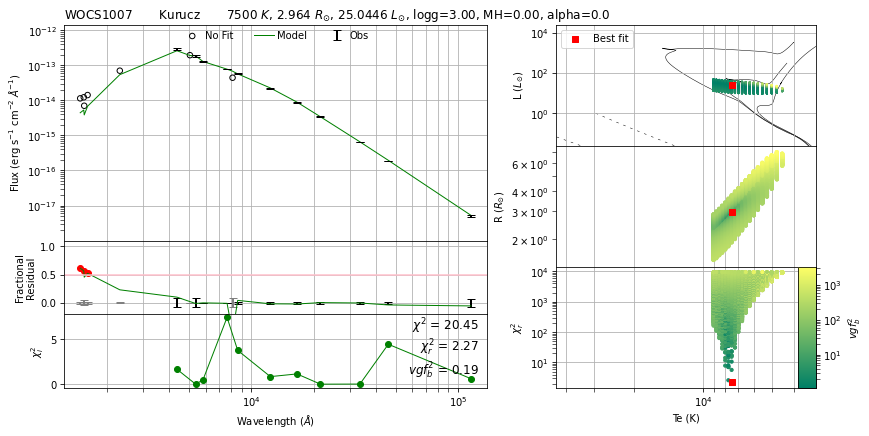

In [3]:
drop_filter_list  = [['KPNO/Mosaic.I'], # WOCS2002
                    ['KPNO/Mosaic.I','GAIA/GAIA3.Gbp']] # WOCS1007

cycle=2
    
idx=1

star_name = star_list[idx]
filters_to_drop = drop_filter_list[idx]

star  = SingleStar(name            = star_name,                           # name of the star
                   model_to_fit    = 'Kurucz',                 # model names same as in "models" folder
                   dir_obs         = 'data/extinction_corrected_flux_files/',             # location of observed SED files
                   distance        = distance,                               # distance in pc
                   distance_err    = e_distance,                                 # distance error in pc
                   free_para       = 2,                                    # number of free parameters
                   filters_to_drop = filters_to_drop,   # list of filters not to be fitted 
                   verbose         = True,
                   wavelength_range= [3000,1000000])
star.read_observed_SED(verbose=True)
star.fit_blackbody(cycle,p0=[5000.,-20])
star.read_model_file(verbose=False)
# keep the sequence and names same as coordinates in the model flux file
limits = {'Te'   : [3500, 9000],
          'logg' : [3.0, 5],
          'MH'   : [0.0, 0.0],
          'alpha': [0.0, 0.0]}
star.constrain_fitting_parameters(limits)
star.create_sf_list(log_sf_flexibility=3., log_sf_stepsize=0.01)    
star.calculate_chi2(cycle, refit=True)
star.get_parameters_from_chi2_minimization(verbose=False)
star.plot_fitted_SED(cycle, excess_cutoff=0.5, folder_path='plots/test/2/')

## 03 - re-running single fits for consistancy and with noise

WOCS2002
----------------
    Calculating noisy chi2:  99/100  (99%)    Creating log_single_fitting.csv and saving log
WOCS1007
----------------
    Calculating noisy chi2:  99/100  (99%)    WARNING: Best fit logg is at lower limit of the model.
    Saving log in log_single_fitting.csv


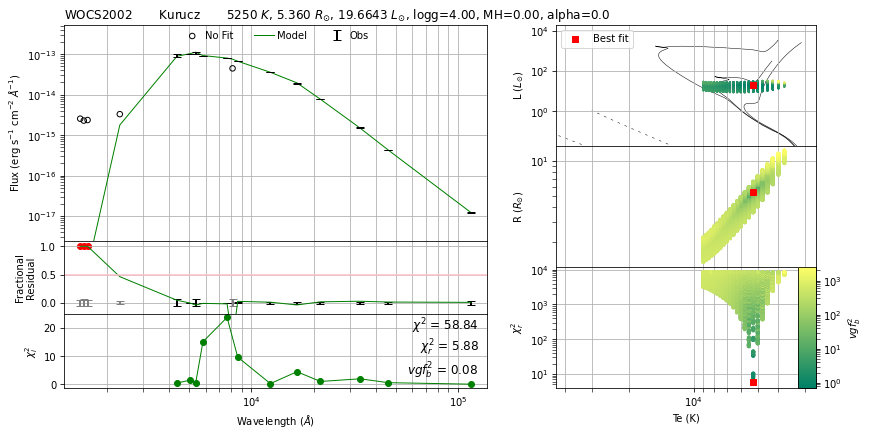

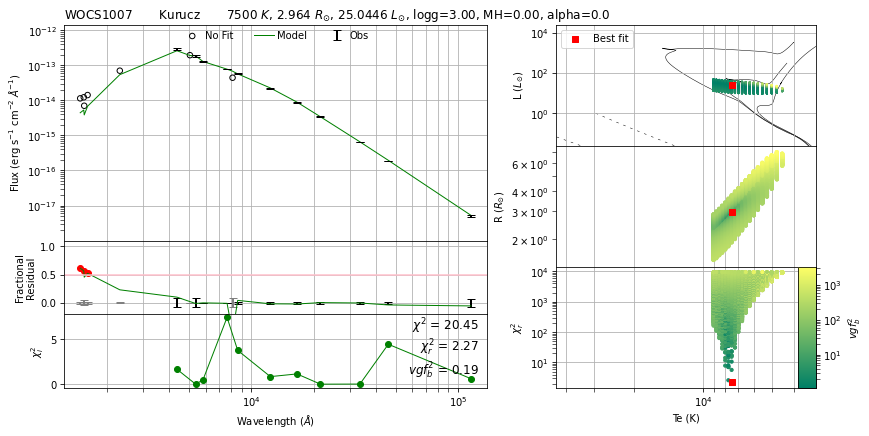

In [4]:
cycle=3

for idx, star_name in enumerate(star_list[:]):
    filters_to_drop = drop_filter_list[idx]

    star  = SingleStar(name            = star_name,                           # name of the star
                       model_to_fit    = 'Kurucz',                 # model names same as in "models" folder
                       dir_obs         = 'data/extinction_corrected_flux_files/',             # location of observed SED files
                       distance        = distance,                               # distance in pc
                       distance_err    = e_distance,                                 # distance error in pc
                       free_para       = 2,                                    # number of free parameters
                       filters_to_drop = filters_to_drop,   # list of filters not to be fitted 
                       verbose         = True,
                       wavelength_range= [3000,1000000])
    star.read_observed_SED()
    star.fit_blackbody(cycle,p0=[5000.,-20])
    star.read_model_file()

    # keep the sequence and names same as coordinates in the model flux file
    limits = {'Te'   : [3500, 9000],
              'logg' : [3.0, 5],
              'MH'   : [0.0, 0.0],
              'alpha': [0.0, 0.0]}

    star.constrain_fitting_parameters(limits)
    star.create_sf_list()    

    star.calculate_chi2(cycle, refit=False)
    star.get_parameters_from_chi2_minimization()
    star.plot_fitted_SED(cycle, excess_cutoff=0.5, folder_path='plots/single_SEDs/')
    
    star.calculate_chi2_noisy(cycle, refit=False)
    star.get_parameters_from_noisy_chi2()
    star.plot_fitted_noisy_SED(cycle, plot_noisy_SEDs=False, show_plot=False,folder_path='plots/single_SEDs/')
    star.save_object(cycle)

# 10 - Double fitting

## 11 - Preliminory binary fit

In [5]:
cycle=11

for idx, star_name in enumerate(star_list[:]):
    filters_to_drop = drop_filter_list[idx]

    single_star = load_SingleStar(star_name, cycle=3)

    binary_star = single_star.to_BinaryStar(model_to_fit_B  = 'Koester', 
                                            free_para       = 2,
                                            filters_to_drop = filters_to_drop,
                                            verbose         = False) 

    binary_star.read_model_file(verbose=False)

    limits = {'Te_B'              :[8000, 30000],
              'logg_B'            :[6.5, 9.5]}
    binary_star.constrain_fitting_parameters(limits)
    binary_star.create_sf_list(R_B_min=0.001, R_B_max=1., log_sf_stepsize=0.01)

    binary_star.calculate_chi2(cycle, refit=True)
    binary_star.get_parameters_from_chi2_minimization()
    binary_star.plot_fitted_SED(cycle, show_plot=False,folder_path='plots/test/11/')

    Calculating chi2:  591/600  (98%)

## 12 - refining binary fits

    Calculating chi2:  591/600  (98%)

FilterID
Astrosat/UVIT.F148W    21.580574
Astrosat/UVIT.F154W     0.885346
Astrosat/UVIT.F169M     9.464230
GALEX/GALEX.NUV        13.498792
KPNO/Mosaic.B           1.057481
KPNO/Mosaic.V           0.200193
GAIA/GAIA3.G           75.010256
GAIA/GAIA3.Grp         60.906651
GAIA/GAIA3.Grvs         1.352189
2MASS/2MASS.J           2.551680
2MASS/2MASS.H           2.918013
2MASS/2MASS.Ks          0.309984
WISE/WISE.W1            0.571361
WISE/WISE.W2            7.466119
WISE/WISE.W3            0.934442
Name: chi2_i, dtype: float64

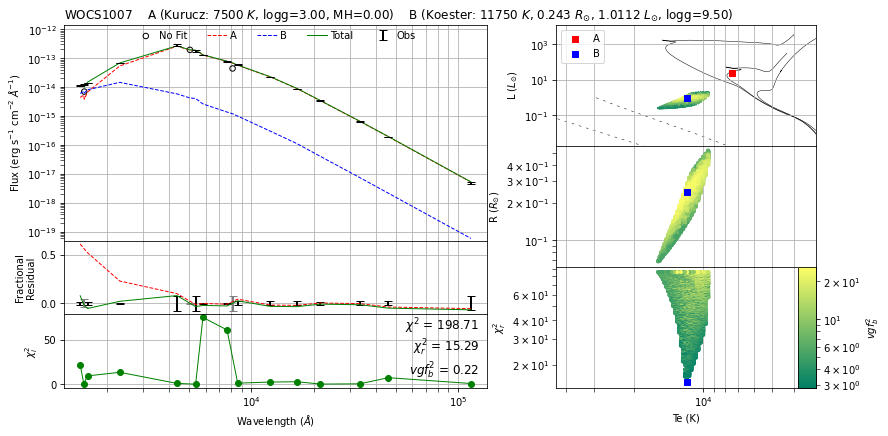

In [6]:
drop_filter_list_2  = [['GALEX/GALEX.NUV','KPNO/Mosaic.I'], # WOCS2002
                    ['GALEX/GALEX.FUV','KPNO/Mosaic.I','GAIA/GAIA3.Gbp']] # WOCS1007

cycle=12

idx=1

star_name = star_list[idx]
filters_to_drop = drop_filter_list_2[idx]

single_star = load_SingleStar(star_name, cycle=3)

binary_star = single_star.to_BinaryStar(model_to_fit_B  = 'Koester', 
                                        free_para       = 2,
                                        filters_to_drop = filters_to_drop,
                                        verbose         = False) 

binary_star.read_model_file()

limits = {'Te_B'              :[4000, 50000],
          'logg_B'            :[6.5, 9.5]}
R_B_min, R_B_max = 0.001, 1.0
if star_name == 'star1':
    limits = {'Te_B'              :[10000, 80000],
              'logg_B'            :[6.5, 9.5]}
    R_B_min, R_B_max = 0.00001, .01
if star_name == 'star8':
    limits = {'Te_B'              :[10000, 80000],
              'logg_B'            :[6.5, 9.5]}
    R_B_min, R_B_max = 0.0001, .1
    
binary_star.constrain_fitting_parameters(limits)
binary_star.create_sf_list(R_B_min, R_B_max, log_sf_stepsize=0.01)

binary_star.calculate_chi2(cycle, refit=True)
binary_star.get_parameters_from_chi2_minimization()
binary_star.plot_fitted_SED(cycle, show_plot=True,folder_path='plots/test/12/')

binary_star.flux.chi2_i

## 13 - re-running binary fits for consistancy and with noise

In [7]:
cycle=13

for idx, star_name in enumerate(star_list[:]):

    filters_to_drop = drop_filter_list_2[idx]

    single_star = load_SingleStar(star_name, cycle=3,verbose = False)

    binary_star = single_star.to_BinaryStar(model_to_fit_B  = 'Koester', 
                                            free_para       = 4,
                                            filters_to_drop = filters_to_drop,
                                            verbose         = False) 

    binary_star.read_model_file(verbose=False)


    limits = {'Te_B'              :[7000, 30000],
              'logg_B'            :[6.5, 9.5]}
    R_B_min, R_B_max = 0.001, 1.0
    if star_name == 'star1':
        limits = {'Te_B'              :[10000, 80000],
                  'logg_B'            :[6.5, 9.5]}
        R_B_min, R_B_max = 0.00001, .01
    if star_name == 'star8':
        limits = {'Te_B'              :[10000, 80000],
                  'logg_B'            :[6.5, 9.5]}
        R_B_min, R_B_max = 0.0001, .1
        
    binary_star.constrain_fitting_parameters(limits)
    binary_star.create_sf_list(R_B_min, R_B_max, log_sf_stepsize=0.01)

    binary_star.calculate_chi2(cycle, refit=False)
    binary_star.get_parameters_from_chi2_minimization()
    binary_star.plot_fitted_SED(cycle, show_plot=False, folder_path='plots/binary_SEDs/')

    binary_star.calculate_chi2_noisy(cycle, total_iterations=100, refit=False)
    binary_star.get_parameters_from_noisy_chi2()
    binary_star.plot_fitted_noisy_SED(cycle,plot_noisy_SEDs=True, show_plot=False, folder_path='plots/binary_SEDs/')

    binary_star.save_object(cycle)

    Calculating noisy chi2:  99/100  (99%)    WARNING: Best fit logg is at upper limit of the model.
    Plotting noisy SEDs:  96/100  (96%)    Creating log_binary_fitting.csv and saving log
    Calculating noisy chi2:  99/100  (99%)    WARNING: Best fit logg is at upper limit of the model.
    Plotting noisy SEDs:  96/100  (96%)    Saving log in log_binary_fitting.csv
